In [1]:
from IPython.display import display

from sympy import *
init_printing()

from monom import *

In [2]:
t, x, tau, h = symbols(r't, x, tau, h', real=True)
u = Function('u')(t, x)

In [3]:
pda_f, pda_v = (u,), (t, x)
pda_n, pda_clp = (6, 6), (3, 3)
pda_p = Rational(1, 2), Rational(0, 1)

In [4]:
Monom.init([str(v) for v in pda_v], [str(f) for f in pda_f])
pda_var = dict(zip(pda_v, (Monom(i) for i in range(len(pda_v)))))
pda_fun = dict(zip(pda_f, (Monom(pos=i) for i in range(len(pda_f)))))

In [5]:
def T(f, i1, j1):
    return sum(sum(\
        diff(f, t, i, x, j)*(tau*(i1 - pda_p[0]))**i \
                             *(h*(j1 - pda_p[1]))**j/\
                 (factorial(i)*factorial(j))\
        for i in range(pda_n[0]))\
        for j in range(pda_n[1]))

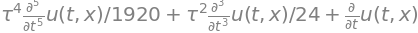

In [6]:
expand((T(u, 1, 0) - T(u, 0, 0))/(tau))

In [7]:
def clip(f):
    f = f.expand()
    r = []
    for i in range(pda_clp[0]):
        for j in range(pda_clp[1]):
            c = f.coeff(tau, i).coeff(h, j)
            if c and (\
            (pda_clp[0]-1 != i or j == 0) and \
            (pda_clp[1]-1 != j or i == 0)):
                r.append(((i, j), c))
    return r

def df2m(a):
    assert a.func == Derivative
    m = pda_fun[a.args[0]]
    for xi in a.args[1:]:
        if isinstance(xi, Symbol):
            m = m*pda_var[xi]
        else:
            m = m*pda_var[xi[0]]**xi[1]
    return m

def m2df(m):
    r = pda_f[m.position()]
    for i in range(len(m)):
        r = r.diff(pda_v[i], m[i])
    return r

def findDiv(a, d):
    r = None
    def find(a, r):
        if a.args:
            if a.func == Derivative and a.args[0] in pda_fun:
                m = df2m(a)
                if m.divisible(d) and (not r or m.cmp(r) > 0):
                    r = m
            else:
                for s in a.args:
                    r = find(s, r)
        return r
    return find(a, r)

def mult(a, s):
    r = []
    for mc in a:
        m = mc[0][0] + s[0], mc[0][1] + s[1]
        if m[0] < pda_clp[0] and m[1] < pda_clp[1] and\
           (pda_clp[0]-1 != m[0] or m[1] == 0) and \
           (pda_clp[1]-1 != m[1] or m[0] == 0):
            r.append((m, mc[1]))
    return r

def add(a, b):
    r, ia, ib = [], 0, 0
    iaend, ibend = len(a), len(b)
    while ia < iaend and ib < ibend:
        ma, mb = a[ia][0], b[ib][0]
        if ma[0] > mb[0]:
            c = 1
        elif ma[0] < mb[0]:
            c = -1
        elif ma[1] > mb[1]:
            c = 1
        elif ma[1] < mb[1]:
            c = -1
        else:
            c = 0
        
        if c == -1:
            r.append(a[ia])
            ia += 1
        elif c == 1:
            r.append(b[ib])
            ib += 1
        else:
            d = expand(a[ia][1] + b[ib][1])
            if d:
                r.append((ma, d))
            ia += 1
            ib += 1
    while ia < iaend:
        r.append(a[ia])
        ia += 1
    while ib < ibend:
        r.append(b[ib])
        ib += 1
    return r

def reduction(f1, f2, m, c, shift):
#     print(m, c, shift)
    f = mult(f2, shift)
    if not m:
        f = [(s, c*p) for s, p in f]
    else:
        f = [(s, c*p.diff(*m)) for s, p in f]
    return add(f1, f)

def NF(f, df, G, head=False):
    assert len(df) == len(G)
    ms = [df2m(d) for d in df]
    i = 0 if head else 1
    while i < len(f):
        shift, p = f[i]
        while True:
            r = None
            for l in range(len(ms)):
                r = findDiv(p, ms[l])
                if r:
                    break
            if not r: 
                break
            m = m2df(r)
            deg = p.as_poly(m).degree()
            c = p.coeff(m, deg)
            if deg > 1:
                c = p.coeff(m, deg)*m**(deg - 1)
            m = r/ms[l]
            d = []
            for k in range(len(pda_v)):
                if m[k] > 0:
                    d.append(pda_v[k])
                    if m[k] > 1:
                        d.append(m[k])
            f = reduction(f, G[l], tuple(d), -c/G[l][0][1].coeff(df[l]), shift)
            if i == len(f):
                break
            shift, p = f[i]
        i += 1
    return f

def compact(f):
    def cmpct(a):
        if not a.args:
            return a
        else:
            if a in pda_f:
                return Symbol("%s" % a.func, real=True)
            elif a.func == Derivative:
                m = []
                for xi in a.args[1:]:
                    if isinstance(xi, Symbol):
                        m.append(str(xi))
                    else:
                        m.append(str(xi[0])*xi[1])
                return Symbol("%s_{%s}" % (a.args[0].func, "".join(m)), real=True)
            else:
                return a.func(*tuple(cmpct(s) for s in a.args))
    return cmpct(f)

def prn(a, p=None):
    for m, c in a:
        s = ""
        if m[0]:
            if m[0] == 1:
                s += "tau"
            else:
                s += "tau^%d" % m[0]
        if m[1]:
            if m[0]:
                s += " "
            if m[1] == 1:
                s += "h"
            else:
                s += "h^%d" % m[1]
        if s:
            print("%s =>" % s)
        if p:
            display(compact(c).collect(p, factor))
        else:
            display(compact(c))

rlen = []
def prnlatex(a, p=None):
    first = True
    for m, c in a:
        s = ""
        if m[0]:
            if m[0] == 1:
                s += r"\tau"
            else:
                s += r"\tau^%d" % m[0]
        if m[1]:
            if m[0]:
                s += " "
            if m[1] == 1:
                s += "h"
            else:
                s += r"h^%d" % m[1]
        if s:
            if first:
                first = False
                print(r"%s\Big(" % s)
            else:
                print(r" + %s\Big(" % s)
        if p:
            print(latex(compact(c).collect(p, factor)))
        else:
            print(latex(compact(c)))
        if first:
            first = False
        else:
            print(r"\Big)")
    rlen.append((len(a[1][1].args), len(a[2][1].args)))
    print(rlen[-1])

In [8]:
def Dt(a):
    return (T(a, 1, 0) - T(a, -1, 0))/(2*tau)
def D2x(a, i):
    return (T(a, i, 1) - T(a, i, -1))/(2*h)
def D2xxx(a, i):
    return (T(a, i, 2) - 2*T(a, i, 1) + 2*T(a, i, -1) - T(a, i, -2))/(2*h**3)

N.J. Zabusky and M.D. Kruskal: Interaction of “solitons” in a collisionless plasma and the recurrence of initial states, Phys. Rev. Lett. 15, 240 (1965)

we explicit scheme with $O(\tau^2, h^2)$ approximation:
\begin{align}
 u^{n+1}_{i} =& u^{n-1}_{i} -\dfrac{2 \tau}{h}\left(u^{n}_{i+1} + u^{n}_{i} + u^{n}_{i-1}\right) \left(u^{n}_{i+1} - u^{n}_{i-1}\right)\\
 & - \dfrac{\tau}{h^3}\left(u^{n}_{i+2} - 2u^{n}_{i+1} + 2u^{n}_{i-1} - u^{n}_{i-2}\right)
\end{align}

In [9]:
Monom.cmp = Monom.TOPlex
pda_n, pda_clp = (6, 6), (3, 3)
pda_p = Rational(0, 2), Rational(0, 1)

In [10]:
F = clip(Dt(u) + 2*(T(u, 0, 1) + T(u, 0, 0) + T(u, 0, -1))*D2x(u, 0) + D2xxx(u, 0))
prn(F)
prnlatex(F)

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\Big(
u u_{xxx} + \frac{u_{xxxxx}}{4} + 2 u_{xx} u_{x}
\Big)
 + \tau^2\Big(
\frac{u_{ttt}}{6}
\Big)
(3, 2)


In [11]:
Ffda = NF(F, [u.diff(t)], [F], head=False)
prn(Ffda)
prnlatex(Ffda)

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\Big(
u u_{xxx} + \frac{u_{xxxxx}}{4} + 2 u_{xx} u_{x}
\Big)
 + \tau^2\Big(
- 36 u^{3} u_{xxx} - 18 u^{2} u_{xxxxx} - 324 u^{2} u_{xx} u_{x} - 3 u u_{xxxxxxx} - 126 u u_{xxxx} u_{x} - 198 u u_{xxx} u_{xx} - 216 u u_{x}^{3} - \frac{u_{xxxxxxxxx}}{6} - 12 u_{xxxxxx} u_{x} - 27 u_{xxxxx} u_{xx} - 42 u_{xxxx} u_{xxx} - 162 u_{xxx} u_{x}^{2} - 198 u_{xx}^{2} u_{x}
\Big)
(3, 13)


we explicit scheme with $O(\tau^2, h^2)$ approximation:
\begin{align}
 u^{n+1}_{i} =& u^{n-1}_{i} -\dfrac{\alpha \tau}{h}u^{n}_{i}\left(u^{n}_{i+1} - u^{n}_{i-1}\right)\\
 & - \dfrac{\beta \tau}{h^3}\left(u^{n}_{i+2} - 2u^{n}_{i+1} + 2u^{n}_{i-1} - u^{n}_{i-2}\right) \tag{1.80}
\end{align}

for sufficiently small steps
\begin{equation}
\tau  \leq \dfrac{2h^3}{3\sqrt{3}\beta} \cong 0.384\dfrac{h^3}{\beta} \tag{1.81}
\end{equation}

In [12]:
Monom.cmp = Monom.TOPlex
pda_n, pda_clp = (6, 6), (3, 3)
pda_p = Rational(0, 2), Rational(0, 1)

In [13]:
F = clip(Dt(u) + 6*T(u, 0, 0)*D2x(u, 0) + D2xxx(u, 0))
prn(F)
prnlatex(F)

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\Big(
u u_{xxx} + \frac{u_{xxxxx}}{4}
\Big)
 + \tau^2\Big(
\frac{u_{ttt}}{6}
\Big)
(2, 2)


In [14]:
Ffda = NF(F, [u.diff(t)], [F], head=False)
prn(Ffda)
prnlatex(Ffda)

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\Big(
u u_{xxx} + \frac{u_{xxxxx}}{4}
\Big)
 + \tau^2\Big(
- 36 u^{3} u_{xxx} - 18 u^{2} u_{xxxxx} - 324 u^{2} u_{xx} u_{x} - 3 u u_{xxxxxxx} - 126 u u_{xxxx} u_{x} - 198 u u_{xxx} u_{xx} - 216 u u_{x}^{3} - \frac{u_{xxxxxxxxx}}{6} - 12 u_{xxxxxx} u_{x} - 27 u_{xxxxx} u_{xx} - 42 u_{xxxx} u_{xxx} - 162 u_{xxx} u_{x}^{2} - 198 u_{xx}^{2} u_{x}
\Big)
(2, 13)


we explicit scheme with $O(\tau^2, h^4)$ approximation:
\begin{align}
 u^{n+1}_{i} =& u^{n-1}_{i} 
    +\dfrac{\alpha \tau}{6h}u^{n}_{i}\left(u^{n}_{i+2} - 8u^{n}_{i+1} + 8u^{n}_{i-1} - u^{n}_{i-2}\right)\\
 & + \dfrac{\beta \tau}{4h^3}\left(u^{n}_{i+3} - 8u^{n}_{i+2} + 13u^{n}_{i+1} - 
                                   13u^{n}_{i-1} + 8u^{n}_{i-2} - u^{n}_{i-3}\right) \tag{1.82}
\end{align}

for sufficiently small steps
\begin{equation}
\tau  \leq \dfrac{108h^3}{(43 + 7\sqrt{73})\sqrt{10\sqrt{73} - 62}\beta} \cong 0.216\dfrac{h^3}{\beta} \tag{1.83}
\end{equation}

In [15]:
def D4x(a, i):
    return -(T(a, i, 2) - 8*T(a, i, 1) + 8*T(a, i, -1) - T(a, i, -2))/(12*h)
def D4xxx(a, i):
    return -(T(a, i, 3) - 8*T(a, i, 2) + 13*T(a, i, 1) -\
             13*T(a, i, -1) + 8*T(a, i, -2) - T(a, i, -3))/(8*h**3)

In [16]:
Monom.cmp = Monom.TOPlex
pda_n, pda_clp = (6, 8), (3, 5)
pda_p = Rational(0, 2), Rational(0, 1)

In [17]:
F = clip(Dt(u) + 6*T(u, 0, 0)*D4x(u, 0) + D4xxx(u, 0))
prn(F)
prnlatex(F)

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\Big(
- \frac{u u_{xxxxx}}{5} - \frac{7 u_{xxxxxxx}}{120}
\Big)
 + \tau^2\Big(
\frac{u_{ttt}}{6}
\Big)
(2, 2)


In [18]:
Ffda = NF(F, [u.diff(t)], [F], head=False)
prn(Ffda)
prnlatex(Ffda)

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\Big(
- \frac{u u_{xxxxx}}{5} - \frac{7 u_{xxxxxxx}}{120}
\Big)
 + \tau^2\Big(
- 36 u^{3} u_{xxx} - 18 u^{2} u_{xxxxx} - 324 u^{2} u_{xx} u_{x} - 3 u u_{xxxxxxx} - 126 u u_{xxxx} u_{x} - 198 u u_{xxx} u_{xx} - 216 u u_{x}^{3} - \frac{u_{xxxxxxxxx}}{6} - 12 u_{xxxxxx} u_{x} - 27 u_{xxxxx} u_{xx} - 42 u_{xxxx} u_{xxx} - 162 u_{xxx} u_{x}^{2} - 198 u_{xx}^{2} u_{x}
\Big)
(2, 13)


we Implicit   scheme with $O(\tau^2, h^2)$ approximation:
\begin{multline*}
\frac{{u}_{j}^{n+1} -{u}_{j}^{n} }{\tau }
 +\frac{\alpha}{4h}\left[{u}_{j}^{n}\left({u}_{j+1}^{n+1} - {u}_{j-1}^{n+1}\right) +
              {u}_{j}^{n+1}\left({u}_{j+1}^{n} - {u}_{j-1}^{n}\right)\right] + \\
 +\frac{\beta}{4h^{3}}\left(\left({u}_{j+2}^{n+1} -2{u}_{j+1}^{n+1} +2{u}_{j-1}^{n+1} -{u}_{j-2}^{n+1}\right) +
             \left({u}_{j+2}^{n} -2{u}_{j}^{n} +2{u}_{j-1}^{n} -{u}_{j-2}^{n}\right)\right)=0.  \tag{1.96}
\end{multline*}

In [19]:
def Dt(a):
    return (T(a, 1, 0) - T(a, 0, 0))/(tau)

In [20]:
Monom.cmp = Monom.TOPlex
pda_n, pda_clp = (6, 6), (3, 3)
pda_p = Rational(1, 2), Rational(0, 1)

In [21]:
F = clip(Dt(u) + 6*(T(u, 0, 0)*D2x(u, 1) + T(u, 1, 0)*D2x(u, 0))/2 + (D2xxx(u, 1) + D2xxx(u, 0))/2)
prn(F)
prnlatex(F)

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\Big(
u u_{xxx} + \frac{u_{xxxxx}}{4}
\Big)
 + \tau^2\Big(
\frac{3 u u_{ttx}}{4} + \frac{u_{ttt}}{24} + \frac{u_{ttxxx}}{8} + \frac{3 u_{tt} u_{x}}{4} - \frac{3 u_{tx} u_{t}}{2}
\Big)
(2, 5)


In [22]:
Ffda = NF(F, [u.diff(t)], [F], head=False)
prn(Ffda)
prnlatex(Ffda)

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\Big(
u u_{xxx} + \frac{u_{xxxxx}}{4}
\Big)
 + \tau^2\Big(
18 u^{3} u_{xxx} + 9 u^{2} u_{xxxxx} + 54 u^{2} u_{xx} u_{x} + \frac{3 u u_{xxxxxxx}}{2} + 45 u u_{xxxx} u_{x} + 81 u u_{xxx} u_{xx} + \frac{u_{xxxxxxxxx}}{12} + 6 u_{xxxxxx} u_{x} + \frac{27 u_{xxxxx} u_{xx}}{2} + 18 u_{xxxx} u_{xxx} + 63 u_{xxx} u_{x}^{2} + 99 u_{xx}^{2} u_{x}
\Big)
(2, 12)


we Implicit scheme with $O(\tau^2, h^4)$ approximation:
\begin{multline*}
\frac{{u}_{j}^{n+1} -{u}_{j}^{n} }{\tau }
 =\frac{\alpha}{4h}\left[{u}_{j}^{n}\left({u}_{j+2}^{n+1} - 8{u}_{j+1}^{n+1} + 8{u}_{j-1}^{n+1} - {u}_{j-2}^{n+1}\right) 
              + {u}_{j}^{n+1}\left({u}_{j+2}^{n} - 8{u}_{j+1}^{n} + 8{u}_{j-1}^{n} - {u}_{j-2}^{n}\right)\right] + \\
 +\frac{\beta}{4h^{3}}\left(\left({u}_{j+3}^{n+1} - 8{u}_{j+2}^{n+1} + 13{u}_{j+1}^{n+1} 
                                  - 13{u}_{j-1}^{n+1} + 8{u}_{j-2}^{n+1} - {u}_{j-3}^{n+1}\right) +
             \left({u}_{j+3}^{n} - 8{u}_{j+2}^{n} + 13{u}_{j+1}^{n} 
                                  - 13{u}_{j-1}^{n} + 8{u}_{j-2}^{n} - {u}_{j-3}^{n}\right)\right).  \tag{1.84}
\end{multline*}

In [23]:
Monom.cmp = Monom.TOPlex
pda_n, pda_clp = (6, 8), (3, 5)
pda_p = Rational(1, 2), Rational(0, 1)

In [24]:
F = clip(Dt(u) + 6*(T(u, 0, 0)*D4x(u, 1) + T(u, 1, 0)*D4x(u, 0))/2 + (D4xxx(u, 1) + D4xxx(u, 0))/2)
prn(F)
prnlatex(F)

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\Big(
- \frac{u u_{xxxxx}}{5} - \frac{7 u_{xxxxxxx}}{120}
\Big)
 + \tau^2\Big(
\frac{3 u u_{ttx}}{4} + \frac{u_{ttt}}{24} + \frac{u_{ttxxx}}{8} + \frac{3 u_{tt} u_{x}}{4} - \frac{3 u_{tx} u_{t}}{2}
\Big)
(2, 5)


In [25]:
Ffda = NF(F, [u.diff(t)], [F], head=False)
prn(Ffda)
prnlatex(Ffda)

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\Big(
- \frac{u u_{xxxxx}}{5} - \frac{7 u_{xxxxxxx}}{120}
\Big)
 + \tau^2\Big(
18 u^{3} u_{xxx} + 9 u^{2} u_{xxxxx} + 54 u^{2} u_{xx} u_{x} + \frac{3 u u_{xxxxxxx}}{2} + 45 u u_{xxxx} u_{x} + 81 u u_{xxx} u_{xx} + \frac{u_{xxxxxxxxx}}{12} + 6 u_{xxxxxx} u_{x} + \frac{27 u_{xxxxx} u_{xx}}{2} + 18 u_{xxxx} u_{xxx} + 63 u_{xxx} u_{x}^{2} + 99 u_{xx}^{2} u_{x}
\Big)
(2, 12)


В результате получим следующую разностную схему для уравнения~(1.18), 
аналогичную схеме Кранка--Николсона для уравнения теплопроводности
\begin{multline*}
\frac{{u}_{j}^{n+1} -{u}_{j}^{n} }{\tau }
 +\alpha\frac{\left({u^2}_{j+1}^{n+1} - {u^2}_{j-1}^{n+1}\right) +
              \left({u^2}_{j+1}^{n} - {u^2}_{j-1}^{n}\right)}{8h} + \\
 +\beta\frac{\left({u}_{j+2}^{n+1} -2{u}_{j+1}^{n+1} +2{u}_{j-1}^{n+1} -{u}_{j-2}^{n+1}\right) +
             \left({u}_{j+2}^{n} -2{u}_{j}^{n+1} +2{u}_{j-1}^{n} -{u}_{j-2}^{n}\right)}{4h^{3}}=0.
\end{multline*}

In [26]:
Monom.cmp = Monom.TOPlex
pda_n, pda_clp = (6, 6), (3, 3)
pda_p = Rational(0, 2), Rational(0, 1)

In [27]:
F = clip(Dt(u) + 3*(D2x(u**2, 1) + D2x(u**2, 0))/2 + (D2xxx(u, 1) + D2xxx(u, 0))/2)
prn(F)
prnlatex(F)

h^2 =>


tau =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\Big(
u u_{xxx} + \frac{u_{xxxxx}}{4} + 3 u_{xx} u_{x}
\Big)
 + \tau\Big(
3 u u_{tx} + \frac{u_{tt}}{2} + \frac{u_{txxx}}{2} + 3 u_{t} u_{x}
\Big)
 + \tau^2\Big(
\frac{3 u u_{ttx}}{2} + \frac{u_{ttt}}{6} + \frac{u_{ttxxx}}{4} + \frac{3 u_{tt} u_{x}}{2} + 3 u_{tx} u_{t}
\Big)
(3, 4)


In [28]:
Ffda = NF(F, [u.diff(t)], [F], head=False)
prn(Ffda)
prnlatex(Ffda)

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\Big(
u u_{xxx} + \frac{u_{xxxxx}}{4} + 3 u_{xx} u_{x}
\Big)
 + \tau^2\Big(
18 u^{3} u_{xxx} + 9 u^{2} u_{xxxxx} + 162 u^{2} u_{xx} u_{x} + \frac{3 u u_{xxxxxxx}}{2} + 63 u u_{xxxx} u_{x} + 99 u u_{xxx} u_{xx} + 108 u u_{x}^{3} + \frac{u_{xxxxxxxxx}}{12} + 6 u_{xxxxxx} u_{x} + \frac{27 u_{xxxxx} u_{xx}}{2} + 21 u_{xxxx} u_{xxx} + 81 u_{xxx} u_{x}^{2} + 99 u_{xx}^{2} u_{x}
\Big)
(3, 13)


Наша $O(\tau^2, h^4)$:
\begin{multline*}
\frac{{u}_{j}^{n+1} -{u}_{j}^{n} }{\tau }
 - \frac{3}{24h}\left(\left({u^2}_{j+2}^{n+1} - 8{u^2}_{j+1}^{n+1} + 8{u^2}_{j-1}^{n+1} - {u^2}_{j-2}^{n+1}\right) 
              + \left({u^2}_{j+2}^{n} - 8{u^2}_{j+1}^{n} + 8{u^2}_{j-1}^{n} - {u^2}_{j-2}^{n}\right)\right) + \\
 - \frac{1}{16h^{3}}\left(\left({u}_{j+3}^{n+1} - 8{u}_{j+2}^{n+1} + 13{u}_{j+1}^{n+1} 
                                  - 13{u}_{j-1}^{n+1} + 8{u}_{j-2}^{n+1} - {u}_{j-3}^{n+1}\right) + \right. \\ \left.
             \left({u}_{j+3}^{n} - 8{u}_{j+2}^{n} + 13{u}_{j+1}^{n} 
                                  - 13{u}_{j-1}^{n} + 8{u}_{j-2}^{n} - {u}_{j-3}^{n}\right)\right)=0
\end{multline*}

In [29]:
Monom.cmp = Monom.TOPlex
pda_n, pda_clp = (6, 8), (3, 5)
pda_p = Rational(1, 2), Rational(0, 1)

In [30]:
F = clip(Dt(u) + 3*(D4x(u**2, 1) + D4x(u**2, 0))/2 + (D4xxx(u, 1) + D4xxx(u, 0))/2)
prn(F)
prnlatex(F)

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\Big(
- \frac{u u_{xxxxx}}{5} - \frac{7 u_{xxxxxxx}}{120} - u_{xxxx} u_{x} - 2 u_{xxx} u_{xx}
\Big)
 + \tau^2\Big(
\frac{3 u u_{ttx}}{4} + \frac{u_{ttt}}{24} + \frac{u_{ttxxx}}{8} + \frac{3 u_{tt} u_{x}}{4} + \frac{3 u_{tx} u_{t}}{2}
\Big)
(4, 5)


In [31]:
Ffda = NF(F, [u.diff(t)], [F], head=False)
prn(Ffda)
prnlatex(Ffda)

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\Big(
- \frac{u u_{xxxxx}}{5} - \frac{7 u_{xxxxxxx}}{120} - u_{xxxx} u_{x} - 2 u_{xxx} u_{xx}
\Big)
 + \tau^2\Big(
18 u^{3} u_{xxx} + 9 u^{2} u_{xxxxx} + 162 u^{2} u_{xx} u_{x} + \frac{3 u u_{xxxxxxx}}{2} + 63 u u_{xxxx} u_{x} + 99 u u_{xxx} u_{xx} + 108 u u_{x}^{3} + \frac{u_{xxxxxxxxx}}{12} + 6 u_{xxxxxx} u_{x} + \frac{27 u_{xxxxx} u_{xx}}{2} + 21 u_{xxxx} u_{xxx} + 81 u_{xxx} u_{x}^{2} + 99 u_{xx}^{2} u_{x}
\Big)
(4, 13)


In [32]:
for l in rlen[0::2]:
    print(l)

(3, 2)
(2, 2)
(2, 2)
(2, 5)
(2, 5)
(3, 4)
(4, 5)


In [33]:
for l in rlen[1::2]:
    print(l)

(3, 13)
(2, 13)
(2, 13)
(2, 12)
(2, 12)
(3, 13)
(4, 13)
